# **Aprendizaje no supervisado**

## DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo de clustering popular que se destaca por su capacidad para identificar clusters de formas arbitrarias y manejar puntos de ruido. A diferencia de métodos como K-Means, DBSCAN no requiere que se especifique el número de clusters de antemano, lo cual lo hace especialmente útil en situaciones donde no se conoce la estructura de los datos a priori.

In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs


X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [2]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

los -1 son los que elementos que no entran en ningun grupo, son las x de color rojo que aparece mas abjo en la imagen.

In [3]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [4]:
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

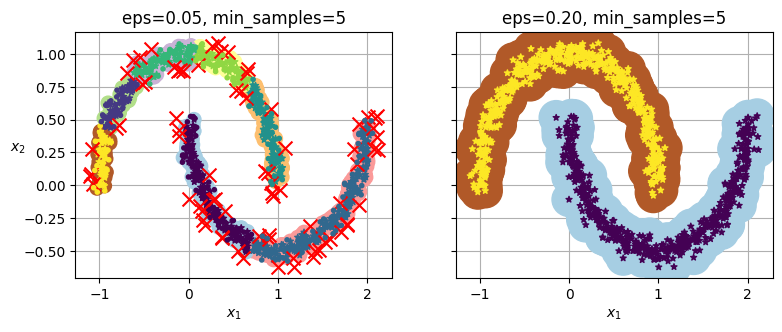

In [5]:

def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

In [11]:
dbscan = dbscan2  # usemos ahora eps=0.2

In [12]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50) # 50 vecinos mas cercanos
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [13]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [14]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

In [15]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

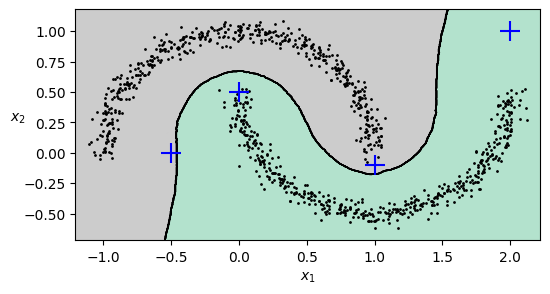

In [16]:

plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

In [17]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1], dtype=int64)

El algoritmo DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es una herramienta eficaz para identificar outliers o puntos de datos ruidosos debido a su naturaleza basada en la densidad. DBSCAN agrupa puntos que están densamente conectados y marca los puntos que no pertenecen a ningún grupo como ruido o outliers. Esto lo convierte en una excelente opción para detectar valores atípicos en conjuntos de datos.

¿Cómo detecta outliers DBSCAN?

1. Puntos densos (core points): Son puntos que tienen al menos un número mínimo de vecinos (definido por el parámetro min_samples) en un radio definido (eps). Estos puntos son considerados "centrales" y son los principales elementos de los clusters.

2. Puntos frontera (border points): Estos puntos no tienen suficientes vecinos para ser puntos densos, pero están dentro de la vecindad de un punto central. Son parte del cluster, pero no lo extienden.

3. Puntos de ruido (outliers): Son puntos que no tienen suficientes vecinos en su vecindad y no están conectados a ningún punto central. DBSCAN marca estos puntos como ruido o outliers.

Parámetros importantes:

- eps: El radio de vecindad en el que se busca vecinos alrededor de cada punto.
- min_samples: El número mínimo de vecinos que un punto debe tener dentro del radio eps para ser considerado un punto denso.

Los outliers son aquellos puntos que no cumplen con estas condiciones y no pertenecen a ningún cluster.

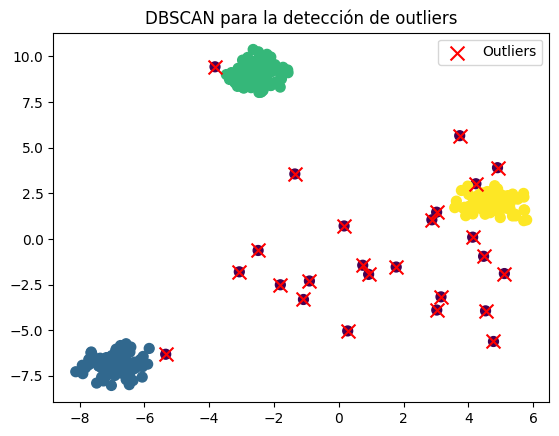

In [ ]:
# Crear datos de ejemplo con blobs y algunos puntos dispersos que serán outliers
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.5, random_state=42)
X = np.concatenate([X, np.random.uniform(low=-6, high=6, size=(20, 2))], axis=0)  # Añadir puntos dispersos

# Definir y ajustar el modelo DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5) # eps=0.5 es la distancia entre puntos , min_samples=5 en numero minimo de puntos que debe tenr cada claseter 
labels = dbscan.fit_predict(X)

# Identificar los outliers (etiqueta -1)
outliers = X[labels == -1]

# Graficar resultados
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.scatter(outliers[:, 0], outliers[:, 1], color='red', marker='x', s=100, label='Outliers')
plt.legend()
plt.title("DBSCAN para la detección de outliers")
plt.show()